# Imports

In [1]:
from pipeline import loading_pipeline
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import KBinsDiscretizer

from model_training import PyTorchModel, evaluate_regression_model, evaluate_classification_model
import transformers

# Preprocessing

In [2]:
X_train, y_train, X_test, y_test = loading_pipeline()

Number of samples: 8600
Signal Length: 2816
X-Shape: (8100, 1408, 2)
y-Shape: (8100,)
X-Shape: (500, 1408, 2)
y-Shape: (500,)
Augmented X.shape: (72900, 1152, 2)
Augmented y.shape: (72900,)


# Transformer

In [3]:
num_classes = len(np.unique(y_train))
print(num_classes)

5


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Quantization
num_bins = 10  # Adjust as needed
kbin = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
kbin.fit(X_train.reshape(-1, 1))

X_train_quantized = kbin.transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], -1)


# Dataset
class TrainingDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]


# DataLoader
train_dataset = TrainingDataset(X_train_quantized, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Using device: cuda:0


In [5]:
# Transformer Model (adapted for your task)
class Transformer(nn.Module):
    def __init__(self, num_tokens, d_model, nhead, num_classes, num_layers=2):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(num_tokens, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = self.embedding(src.long()).mean(dim=2)  # Embed and average the two signals
        src = src.permute(1, 0, 2)  # Reshape for transformer: [seq_len, batch_size, d_model]
        out = self.transformer_encoder(src)
        out = out.mean(dim=0)  # Pooling
        return self.classifier(out)

In [6]:
# Initialize the model
transformer_model = Transformer(num_tokens=num_bins, d_model=64, nhead=4, num_classes=num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

# PyTorchModel Wrapper
model = PyTorchModel(transformer_model, criterion, optimizer, device)

/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/25], Train Loss: 1.0427, Val Loss: 1.0354
Epoch [2/25], Train Loss: 1.0317, Val Loss: 1.0346
Epoch [3/25], Train Loss: 1.0314, Val Loss: 1.0365
Epoch [4/25], Train Loss: 1.0309, Val Loss: 1.0357
Epoch [5/25], Train Loss: 1.0307, Val Loss: 1.0359
Early stopping triggered
Accuracy: 0.204
Precision: 0.09771080846131557
Recall: 0.204
F1-Score: 0.07493026114639643


/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


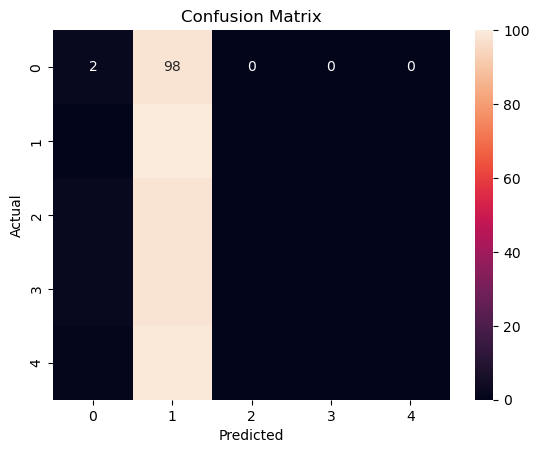


Classification Report:

              precision    recall  f1-score   support

           0       0.29      0.02      0.04       100
           1       0.20      1.00      0.34       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100

    accuracy                           0.20       500
   macro avg       0.10      0.20      0.07       500
weighted avg       0.10      0.20      0.07       500


/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [7]:
evaluate_classification_model(model, X_train, y_train, X_test, y_test)

In [8]:
#todo LOOCV based on candidate-id, select all samples from X number of candidates (men and women balanced maybe)
#todo use currently done test set as validation set
#todo integrate validation set performance metrics into training